In [1]:
import findspark
import os
findspark.init('/home/hadoop/spark')
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
conf = SparkConf().setAppName('Jupyter PySpark Test')
conf.set('spark.yarn.dist.files','file:/home/hadoop/spark/python/lib/pyspark.zip,file:/home/hadoop/spark/python/lib/py4j-0.10.7-src.zip')
conf.setExecutorEnv('PYTHONPATH','pyspark.zip:py4j-0.10.7-src.zip')
conf.setMaster('yarn') # Run on Yarn, not local
sc = SparkContext(conf=conf)

In [2]:
dummy_data = range(1, 100)
dummy_rdd = sc.parallelize(dummy_data)
print(dummy_rdd.filter(lambda x: x<10).collect())

[1, 2, 3, 4, 5, 6, 7, 8, 9]


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession(sc)

In [5]:
imdb_ratings_dataframe = spark.read.format('com.databricks.spark.csv').options(delimiter = '\t',header ='true',nullValue ='null',inferSchema='true').load('hdfs:///user/hadoop/imdb_raw/title_ratings/2018/12/7/title.ratings.tsv')

In [5]:
imdb_ratings_dataframe.show(5) # show first 5 lines of tsv file (now a spark dataframe)

+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt0000001|          5.8|    1418|
|tt0000002|          6.4|     167|
|tt0000003|          6.6|    1013|
|tt0000004|          6.4|     100|
|tt0000005|          6.2|    1712|
+---------+-------------+--------+
only showing top 5 rows



In [6]:
imdb_ratings_dataframe.printSchema() # show schema of tsv file (now dataframe)

root
 |-- tconst: string (nullable = true)
 |-- averageRating: double (nullable = true)
 |-- numVotes: integer (nullable = true)



In [8]:
imdb_ratings_dataframe.count() # show number of rows within dataframe

872954

In [6]:
from pyspark.sql.functions import col, avg
imdb_ratings_dataframe.agg(avg(col("averageRating"))).show() # calculate average movie rating 

+------------------+
|avg(averageRating)|
+------------------+
| 6.929355269579343|
+------------------+



In [11]:
imdb_ratings_dataframe.filter(col('averageRating') > 9.5).show(5) # filter movie ratings > 9.5 and show first 5

+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt0015927|          9.7|       6|
|tt0041069|          9.7|       6|
|tt0050536|          9.7|       7|
|tt0053560|          9.6|       5|
|tt0055416|          9.7|      31|
+---------+-------------+--------+
only showing top 5 rows



In [16]:
imdb_ratings_dataframe.write.format("csv").save("hdfs:///user/hadoop/imdb_ratings") 
# saved on HDFS as /user/hadoop/imdb_ratings/part-00000-ce6e8310-64c0-4fb9-b597-d66a92f5309b-c000.csv

In [7]:
imdb_movies_dataframe = spark.read.format('com.databricks.spark.csv').options(delimiter = '\t',header ='true',nullValue ='null',inferSchema='true').load('hdfs:///user/hadoop/imdb_raw/title_basics/2018/12/7/title.basics.tsv')

In [18]:
all_imdb_dataframe = imdb_ratings_dataframe.join(imdb_movies_dataframe, imdb_ratings_dataframe.tconst == imdb_movies_dataframe.tconst)

In [19]:
all_imdb_dataframe.select("primaryTitle", "startYear", "averageRating", "numVotes").show(5)

+--------------------+---------+-------------+--------+
|        primaryTitle|startYear|averageRating|numVotes|
+--------------------+---------+-------------+--------+
|The Puppet's Nigh...|     1908|          6.5|     126|
|The Lighthouse Ke...|     1911|          7.1|       8|
|    The Sands of Dee|     1912|          6.9|      51|
|Zigomar contre Ni...|     1912|          6.8|      10|
|His Favorite Pastime|     1914|          5.1|     814|
+--------------------+---------+-------------+--------+
only showing top 5 rows



In [25]:
plot_dataframe = imdb_movies_dataframe.filter(col('startYear') != '\N').filter(col('startYear') > 1990).filter(col('titleType') == 'movie').groupBy('startYear').count().sort(col("startYear").desc())

In [30]:
plot_dataframe.show()

+---------+-----+
|startYear|count|
+---------+-----+
|     2115|    1|
|     2025|    1|
|     2024|    4|
|     2023|    1|
|     2022|    7|
|     2021|   33|
|     2020|  205|
|     2019| 3279|
|     2018|19560|
|     2017|18237|
|     2016|17377|
|     2015|16228|
|     2014|15602|
|     2013|14726|
|     2012|13778|
|     2011|12917|
|     2010|11916|
|     2009|11075|
|     2008| 9439|
|     2007| 8024|
+---------+-----+
only showing top 20 rows



In [27]:
import matplotlib.pyplot as plt
import pandas
pd_df=plot_dataframe.select("startYear", "count").toPandas()

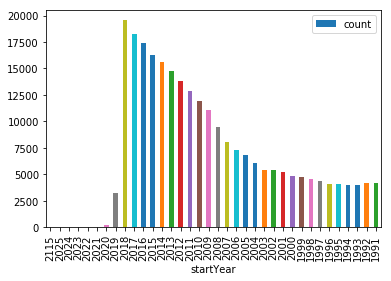

In [29]:
pd_df.plot.bar(x='startYear',y='count')